In [36]:
import numpy as np
import matplotlib.pyplot as  plt
from matplotlib import cm
from tqdm import tqdm

from np_fun import prob, prob_part
#from tf_fun import init as tf_init
from Annealing import Annealer
from numpy import genfromtxt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
tst = lambda z,x: np.sin(z[0]*x+z[1])+z[0]+np.cos(2*z[1])+z[0]*z[1]
carr =lambda f,z: lambda x: f(z,x)
sampl = lambda f,fm=0,to=10,cnt=100: [np.linspace(fm,to,cnt),list(map(f,np.linspace(fm,to,cnt)))]

In [38]:
filenames=[
    './20_07/data_21-07-2018_01-59_port0.csv',
    './20_07/data_21-07-2018_01-59_port1.csv',
    './20_07/data_21-07-2018_01-59_port2.csv',
]
exp_params={
    'scaling_channels':[0.98,1.0,1.14],
    'min_amp_per':[15,80-20,75],
    'start_end_index':[-150,-10],
}

In [33]:
filenames = [
    './20_07/data_21-07-2018_00-03_port0.csv',
    './20_07/data_21-07-2018_00-03_port1.csv',
    './20_07/data_21-07-2018_00-03_port2.csv',
]
exp_params = {
    'scaling_channels':[0.99,1.0,1.0],
    'min_amp_per':[10,80-10,75],
    'start_end_index':[-160,-10],
}

In [1146]:
filenames_ = [
    './data_05-07-2018_20-20_port0.csv',
    './data_05-07-2018_20-30_port1.csv',
    './data_05-07-2018_20-20_port2.csv'
]
exp_params_ = {
    'scaling_channels':[0.99,1.0,1.0],
    'min_amp_per':[40,120-40,100],
    'start_end_index':[-45,-10],
}

In [6]:
filenames = [
        './20_07/data_20-07-2018_22-41_port0.csv',
        './20_07/data_20-07-2018_22-41_port1.csv',        
        './20_07/data_20-07-2018_22-44_port2.csv'
]
exp_params = {
    'scaling_channels':[0.99,1.0,1.0],
    'min_amp_per':[10,80-10,75],
    'start_end_index':[-160,-10],
}

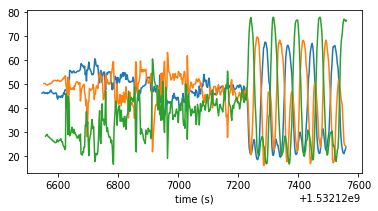

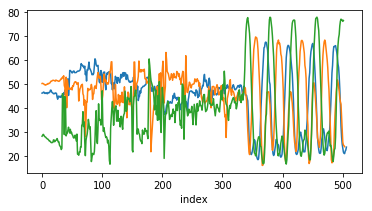

In [468]:
exp_points = [genfromtxt(i, delimiter=',') for i in filenames]
#times = [np.array(exp_points[i].T[1]) for i in range(len(filenames))]
times = [np.array(i.T[1]) for i in exp_points]
exp_points = [np.array(i.T[0]) for i in exp_points]
#exp_points = np.array([ ea[:502] for ea in exp_points])
# plot the data
plt.figure(figsize=(6,3))
plt.xlabel('time (s)')
for i,t in zip(exp_points,times):
    plt.plot(t,i)
plt.figure(figsize=(6,3))
plt.xlabel('index')
for i,t in zip(exp_points,times):
    plt.plot(i)


### Scale data by channel, crop and scale x axis

data and pts shape: (3, 140) (3, 140)
max distance 1 and 2 points array: 0.022763575812437153


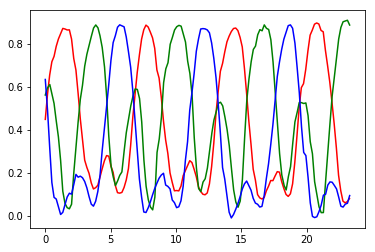

In [469]:
scaling_channels = exp_params['scaling_channels']
exp_points = [exp_points[i]/scaling_channels[i] for i in range(len(exp_points))]
me_min, ampl, per = exp_params['min_amp_per']
start_exp, end_exp = exp_params['start_end_index']

data = np.array([ ep[start_exp:end_exp] for ep in exp_points])
pts = np.array([ t[start_exp:end_exp]-t[start_exp] for t in times])
# inverse the exp data
data = np.fliplr(data)
#pts = np.fliplr(pts)
print('data and pts shape:',data.shape,pts.shape)

data = data - me_min
data /= ampl
pts = pts/per*2*np.pi
colors = (i for i in ['red','green','blue'])
for i,t in zip(data,pts):
    plt.plot(t,i,color=next(colors))
print('max distance 1 and 2 points array:',max(pts[1]-pts[2]))
pts = pts[0]

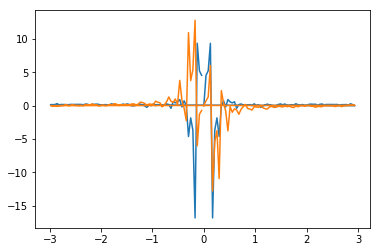

In [470]:
ft = np.fft.fft(data[0]-np.mean(data[0]))
freq = np.fft.fftfreq(ft.shape[-1],d=pts[1])
plt.plot(freq,ft.real)
plt.plot(freq,ft.imag)

75 38 11.668611435239207


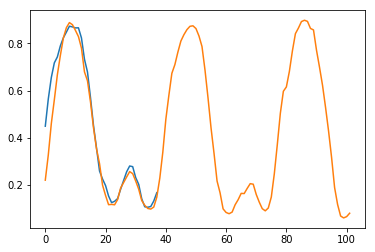

In [471]:
# Check if the chosen period is indeed a period
units_period = 1/0.0857
index = len([x for x in pts if x<6.28])
print(per,index,units_period)
plt.plot(data[0][:index])
plt.plot(data[0][index:])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa86857afd0>,
      dtype=object)

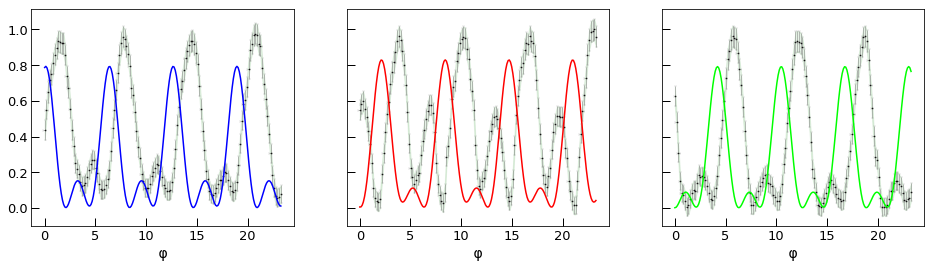

In [636]:
def func(x):
    return np.abs(np.square(prob_part(0,0,0,0,phi=x)))
def set_fonts_ticks(fig,ax):
    fontsize =14
    try:
        ax.set_xlabel(' φ ',fontsize=fontsize)
        #ax.set(ylabel=' Intensity ')
    except:
        plt.ylabel(' Intensity ', fontsize=fontsize)
        plt.xlabel(' φ ',fontsize=fontsize)
    
    tick_width =1
    ax.tick_params(axis="y",direction="in",labelsize=13,width=tick_width,length=8)
    ax.tick_params(axis="x",direction="in",labelsize=13,width=tick_width, length=8)
    
def plot3(func,points_data=(pts,data),on_same=False):
    pts,data = points_data
    lin,d = sampl(func,pts[0],pts[-1],200)
    d = np.array(d).T
    %matplotlib inline
    fs=(16,4)
    if on_same:
        plt.figure(figsize=fs)
        ax =[plt,plt,plt]
        f = plt
    else:
        f,ax = plt.subplots(1,3,figsize=fs,sharey=True)
    colors  = ['blue','red','green']
    colors  = [cm.brg(i) for i in np.linspace(0,1,3)]
    for i,color in zip(range(3),colors):
        #ax[i].errorbar(pts,data[i],xerr=4*np.pi/100,yerr=0.03+0.02*data[i],fmt='none',color='gray',capsize=2)
        errx = 0.05+0.01*np.array(data)
        errx_ = 0.09+0.01*np.array(data)
        ax[i].fill_between(pts,data[i]+errx[i],data[i]-errx[i],color='green',alpha=0.1,label='error region')
        #ax[i].fill_between(pts,data[i]+errx_[i],data[i]-errx_[i],color='green',alpha=0.1)
        ax[i].errorbar(pts,data[i],xerr=4*np.pi/100,yerr=errx[i],capthick=0.2,elinewidth=0.5,fmt='none',color='gray',capsize=1.5)
        set_fonts_ticks(f,ax[i])
        ax[i].plot(pts,data[i],'.',markersize=1,color='black',label=r'data $|%i\rangle$'%i)
        ax[i].plot(lin,d[i],label=r'function $|%i\rangle$'%i,color=color)
    #ax[0].legend(loc=1)
    return ax
    #plt.legend()

plot3(func,on_same=False)

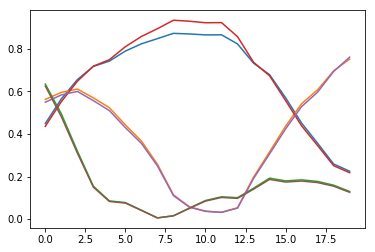

In [473]:
data_orig = data
for d in data_orig:
    plt.plot(d[:20])
transform_fun = lambda x: 1*np.sqrt(np.square(x)*(1+0.5*np.power(x,6)))
data = list(map(transform_fun,data_orig))
data /= np.max(data)
for d in data:
    plt.plot(d[:20])

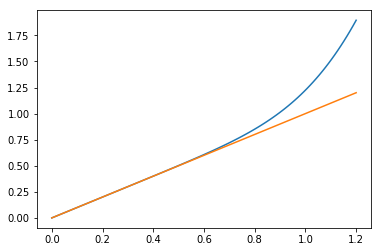

In [474]:
x = np.linspace(0,1.2,100)
y = transform_fun(x)
plt.plot(x,y)
plt.plot(x,x)

In [475]:
fixed = [0,0]
tst = lambda z,x: np.sin(z[0]*x+z[1])+z[0]+np.cos(2*z[1])+z[0]*z[1]
carr =lambda f,z: lambda x: f(z,x)
sampl_map_depr = lambda f,fm=0,to=10,cnt=100: [np.linspace(fm,to,cnt),list(map(f,np.linspace(fm,to,cnt)))]
sampl = lambda f,fm=0,to=10,cnt=100: [np.linspace(fm,to,cnt),f(np.linspace(fm,to,cnt))]
np_map = lambda f,x: np.array(list(map(f, x)))

device = lambda z,x:np.abs(np.square(prob_part(z[0],z[1],fixed[0],fixed[1],phi=x)))
unit = lambda z,x: device(z,x).dot(np.array([0,1,0]).T)
cost = lambda f,data,points=pts: np.sum(np.square(f(points).T-data))
foo = lambda x: unit([0,0],x)

ttt = carr(unit,[0,0])
cost(carr(device,[0,0]),data,pts)


101.91020036329391

In [476]:
def get_parametric(func,dots=50):
    xrange = np.linspace(-7.0, 7.0, dots)
    yrange = np.linspace(-7.0, 7.0, dots)
    p = np.zeros((len(xrange),len(yrange)))
    f2d = lambda x,y:cost(carr(func,[x,y]),data)
    #f2d = lambda x,y:opt.prob(x,y,12)
    for x in tqdm(range(len(xrange))):
        for y in range(len(yrange)):
            p[y,x] =  f2d(xrange[x],yrange[y])
    return xrange,yrange,p

def display_parametric(p):
    best_pos=np.unravel_index( np.argmin(p),p.shape)
    best_pos = [xrange[best_pos[0]], yrange[best_pos[1]]]
    print("Min cost is:",np.min(p),' at position ',best_pos)
    
    %matplotlib notebook
    plt.contourf(xrange,yrange,p,100)
    #plt.savefig('fig.png',dpi=300)
xrange,yrange,p = get_parametric(device)
print()

100%|██████████| 50/50 [00:03<00:00, 14.85it/s]

In [477]:
best_pos=np.unravel_index( np.argmin(p),p.shape)
best_pos = [xrange[best_pos[1]], yrange[best_pos[0]]]
print("Min cost is:",np.min(p),' at position ',best_pos)

Min cost is: 24.648431051175734  at position  [3.857142857142856, 5.571428571428571]


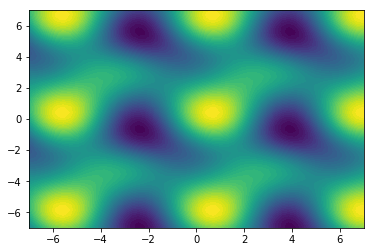

In [478]:

%matplotlib inline
plt.contourf(xrange,yrange,p,50)

#plt.scatter(*np.array(opt.dots).T,c=np.arange(len(opt.dots)),marker='o',alpha=0.7)
#plt.savefig('fig.png',dpi=300)

In [175]:

point = [-0.5,2.52]
point = best_pos
fun = carr(device,point)
print('cost is ',cost(fun,data))
plot3(fun)
#plt.figure(figsize=(15,5))
#plt.plot(pts,data[1],'D')
#plt.plot(*sampl(carr(unit,point),0,14))

TypeError: 'numpy.float64' object is not callable

cost 90.08411661467551


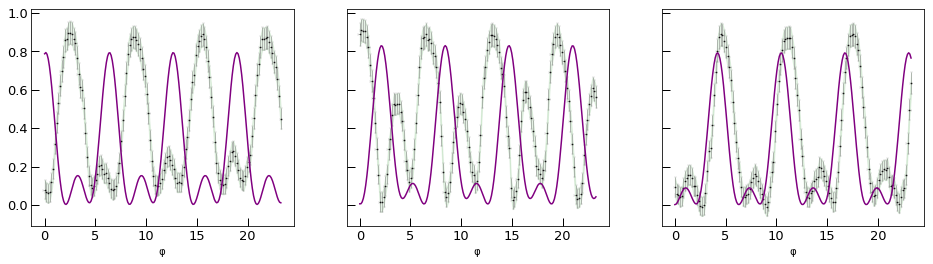

In [15]:
kek = carr(device,[0,0])
carr_dev = lambda x,y:carr(device,[x,y])
print("cost",cost(carr_dev(0,0),data))
plot3(kek)

plt.savefig('./figs/unfitted_cost19.5.eps')

### Optimisation


In [479]:
unit_all = lambda z,x: np.dot([0,1,0],np.abs(np.square(prob_part(z[0],z[1],z[2],z[3]+z[8]*x, phi=z[4]*x+z[5]))).T)*z[6]+z[7]
unit_all_sh = lambda z,x: np.abs(np.square(prob_part(z[0],z[1],z[2],z[3]+z[8]*x, phi=z[4]*x+z[5]))).T*z[6]+z[7]
unit_all = lambda z,x: np.abs(np.square(prob_part(z[0],z[1],z[2],z[3], phi=z[4]*x+z[5]))).T*z[6]+z[7]
def unit_all_ext(z,x):
    scale = np.array([z[6],z[8],z[10]]).reshape(-1,1)
    bias= np.array([z[7],z[9],z[11]]).reshape(-1,1)
    sq = np.abs(np.square(prob_part(z[0],z[1],z[2],z[3], phi=z[4]*x+z[5]))).T
    return np.multiply(sq,scale)+bias
    


In [480]:


opt = Annealer(unit_all_ext,points_data=(pts,data),energy=0.01)
#opt = Annealer(unit_all_sh,points_data=(pts,data),energy=3)
start = [ 1.97826339, 0.61469571, -2.23318571, -2.48897276,-1.56313198,-0.26907035,1.55959301, 0.06752256]
start_1d = [ -4.47259827, -16.59763161,  -0.10024442,  -4.70741011, -1.5601084, 8.85820219,   1.26772687,  -0.01726806]


In [709]:
start = [0,0,0,0,1,0]
#start = [0,0,0,0,-1,0,1,0]
#start = [1.97641972,  0.46830365, -2.34256105, -2.7767623,  1.53977032, -0.45830121]
#start+= [1.5291502, -0.04907852]*3
start+= [1., 0]*3
#start = [1.97641972,  0.46830365, -2.34256105, -2.7767623,  -1.53977032, -0.45830121, 1.48391502, -0.04907852]
#start = [-25.648831,   -16.91017209, -10.20137638 , 11.01714674, 1.12643974, -6.81656814,3.31360078,-0.39924749]
#----
#start = [ 1.97826339, 0.61469571, -2.23318571, -2.48897276,-1.56313198,-0.26907035,1.55959301, 0.06752256]
#start = [ 1.967253,0.48585659,-2.33491508,-2.78094184,-1.54426616,-0.48716136, 1.48614562,-0.04299893]
#start = [ 1.96138566 ,0.50875255,-2.35032956,-2.76200031,-1.54908902,-0.49052423,1.48531792,-0.03484366]
#start = [ 1.9275381  ,0.59061329,-2.34954988,-2.7051162,-1.55274685,-0.45482005,1.48985282,-0.01583345]
#start = [ 1.92458872e+00 ,6.32120251e-01,-2.37815466e+00,-2.69702060e+00,-1.55968124e+00,-4.25383658e-01, 1.49321705e+00,5.56355378e-04]
#start = [ 1.92847165, 0.6375538, -2.36868504,-2.68888271,-1.55939054,-0.42065203]#,1.49548067, 0.00481282]
#-----
#start = [ 2.12656275, 0.47688792,-1.98577565,-2.35514891,-1.55995708,-0.23963736,1.44947365,-0.01452177]
#-----
#start = [1.95919984e+00, 8.19740538e-01,-2.26230497e+00,-2.72042327e+00,-1.55939054e+00,-4.20652030e-01 ,1.53312784e+00 ,1.68078388e-03,1.44252585e+00 ,9.75280255e-02 ,1.48103378e+00,-2.73642836e-02]
#start = [1.95919984e+00, 8.19740538e-01,-2.26230497e+00,-2.72042327e+00,-1.55939054e+00,2.5,1.53312784e+00 ,1.68078388e-03,1.44252585e+00 ,9.75280255e-02 ,1.48103378e+00,-2.73642836e-02]
#start = [0,0,0,0,-1.55939054e+00,2.5,1.53312784e+00 ,1.68078388e-03,1.44252585e+00 ,9.75280255e-02 ,1.48103378e+00,-2.73642836e-02]
#start+= [1.5291502, -0.04907852]*3
#----
#start = [-2.32541952,-0.9608898, -0.13852067,-5.15517973, 0.97465464, 1.31748816, 1.53951879, 0.01011564, 1.02387153 ,-0.06185487,1.36900721,-0.03954456]
#start = [-3.36118403, 0.96926396, 0.10836383,-3.89032361, 0.97549022, 1.93320694,1.6801596, -0.01879222, 1.49163158, 0.07257146, 1.5428213, -0.11929513]
#start = [-3.49121636, 0.87385935,-0.08959715,-3.91629894,0.9750151,1.9603849,1.49616193, 0.0190554,1.36912646,0.10818433,1.36644564,-0.05666999]
#----
#start = [-0.35676228,-0.03535678,-0.43482671,-0.34998957,-0.97160596, 2.38082973,1.12625908, 0.1297592,1.17688177,  0.15757579,  0.99144728,  0.06590635]
#start = [-0.33552876,-0.03830224,-0.18863695,-0.33352386,-0.97145185, 2.39195415,1.22306303, 0.1326142,1.11796584, 0.1699339,  0.98328385,-0.0180364 ] 
#start = [-0.24526258, 0.15732052,-0.19880247,-0.28151031,0.97291334, 2.46447037,1.08338516, 0.11748036, 1.0809959,  0.14362178, 1.18665954, 0.04184873]
#-----
#start = [-0.57306714, 0.63175266,-0.36122907,-0.3208004 ,-0.97451166, 2.54132486,1.181723,0.07407222 ,1.27971451 ,0.10763267,1.22769368 ,0.02456477] 
#-----
#start = [0.07661972,-0.07106976,-0.05549605,-0.11803781, 0.97650235,1.72300005, 1.21218324 ,0.01452341 ,0.97419767 ,0.16275044, 1.10270804 ,0.11445055]
#start = [-0.31160797, 0.10608301,0.05620119,-0.42756725 ,0.9737802,1.86668951,1.24243826, 0.01624791, 1.03994315, 0.15482945, 1.12628097, 0.13422101]
#start = [-0.51848071, 0.44655803,-0.10513339,-0.66608409, 0.9748721,1.80340634,1.27070089,-0.00278106, 1.22260681, 0.09637843, 1.20320884, 0.10860261]
start = [-0.3203845,0.16993224,-0.32911475, 0.01809247, 0.97449245,-1.2447041,1.10730278, 0.10217422, 1.04108196, 0.17192258, 1.20898653, 0.0315673 ]
start = opt.best
#start[8]*=1.1
#start[9]-=0.1

#start[4]=-start[4]
#start[5]=-start[5]

#start[0]*=0.9
#start[1]*=0.9
start[2]*=0.9
#start[3]*=0.95

#start[:4]=[-1.36891766, -0.06588248, -0.20562201, -0.22415281]
##start = point
#start_1d = [ -4.47259827, -16.59763161,  -0.10024442,  -4.70741011 , -1.5601084, 8.85820219,   1.26772687,  -0.01726806]
#start = [ 1.65353401, -0.47372438, -3.24028015, -2.16909992, -1.57036921,  0.08920259, 1.69030152, -0.148071]
scales= np.array([0.5]*4+[0.9,0.9]+[.9,.9]*3)*0.002

#scales= np.array([0,0,0,0,0,0]+[0.2,0.3]*3)*0.05
point,cost = opt.opt(start_point=start,
                     energy=0.0009,
                     scales =scales,
                     max_steps =1000
                    )

print(point,cost)
print(opt.best)

100%|██████████| 1000/1000 [00:02<00:00, 375.35it/s]

[-0.31801119  0.16988895 -0.30951276 -0.01457011  0.97398999 -1.24851197
  1.11575819  0.09997727  1.05859409  0.16770546  1.18452553  0.04111479] 1.6053271911694234
[-0.32014809  0.16810299 -0.31114099 -0.0159109   0.97397716 -1.2481306
  1.11663235  0.09892454  1.05789817  0.1653955   1.18697787  0.04045915]


1.6053271911694234


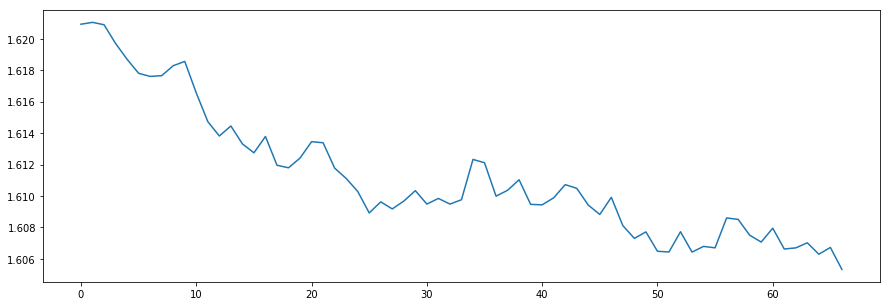

In [710]:
plt.figure(figsize=(15,5))
plt.plot(opt.costs)
print(np.min(opt.costs))

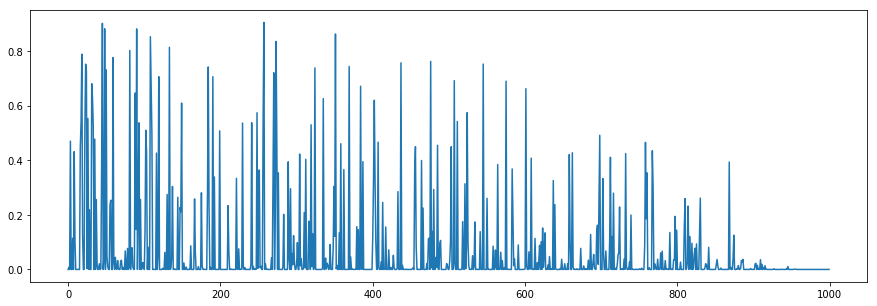

In [711]:

plt.figure(figsize=(15,5))
plt.plot(opt.probs)

-1.2481305967030332
best cost: 8.637415547334648


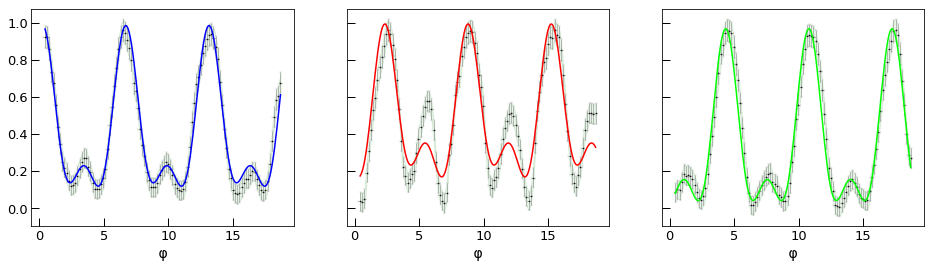

In [723]:
%matplotlib inline
#opt.best+=np.array([0]*8+[0.05,-0.05,0,0])
s = list(opt.best)
bias = s[5]
print(bias)
s[5]=-0.
best_fun= carr(opt.func,s)
fourier_fun= carr(opt.func,[0,0,0,0]+list(opt.best[4:]))
print('best cost:',opt.cost(best_fun))
#plot3(lambda x: best_fun(x).T,on_same=True)
axes = plot3(lambda x: best_fun(x).T,points_data=(opt.points[10:-20]+bias,opt.data[:,10:-20]))
#lin,d = sampl(fourier_fun,pts[0],pts[-1],200)
#for i in range(3):
    #axes[i].plot(lin,d[i],'--')
plt.savefig('figs/fitted_cost1-37_bars.pdf')


In [638]:
%matplotlib inline
%matplotlib inline
unit_all_1 = lambda z,x: np.abs(np.square(prob_part(z[0],z[1],z[2],z[3], phi=z[4]*x+z[5]))).T*z[6]+z[7]
print(opt.best)
def unit_ideal(z,x):
    scale = np.array([z[6],z[8],z[10]]).reshape(-1,1)
    bias= np.array([z[7],z[9],z[11]]).reshape(-1,1)
    sq = np.abs(np.square(prob_part(z[0],z[1],z[2],z[3], phi=z[4]*x+2.5))).T
    return np.multiply(sq,scale)+bias
 
best_fun= carr(unit_ideal,[0,0,0,0]+opt.best[4:])
print(opt.cost(best_fun))
plot3(lambda x: best_fun(x).T,points_data=(opt.points,data))

[-0.35527441  0.16913896 -0.33708346 -0.00456438  0.97478273  0.
  1.13037694  0.09307493  1.06975612  0.16135438  1.18960182  0.04121089]


ValueError: operands could not be broadcast together with shapes (4,) (8,) 

0.0 19.93065334959368
54.971755596152875


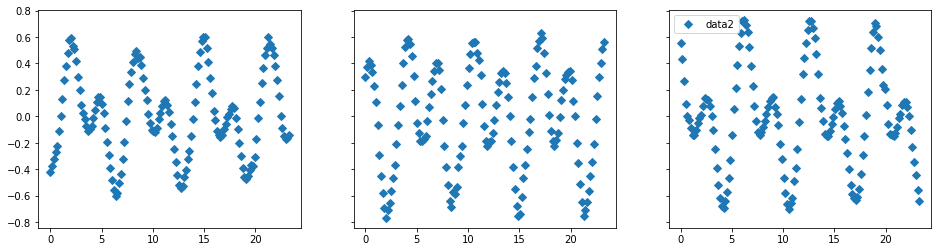

In [719]:
#lin,d = sampl(func,0,12.56,100)
#d = np.array(d).T
print(min(pts),max(pts[:-20]))
f = best_fun(pts)
%matplotlib inline
fs=(16,4)
print(np.sum(np.square(data - f)))
fig,ax = plt.subplots(1,3,figsize=fs,sharey=True)
for i in range(3):
    ax[i].plot(pts, data[i]-f[i],'D',label='data%i'%i)
plt.legend()
best_point = opt.best

In [160]:
print(best_point)


[-0.31305734  0.1920463  -0.28419054 -0.61196897 -0.97602927  2.28265513
  1.0727569   0.14157131  1.2634214   0.02928405  1.05893013  0.04638161]
